In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets
%matplotlib inline

import numpy as np
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt

import os
import shutil
import cv2
from copy import deepcopy

from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from time import time
from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn import metrics
import json
from pathlib import Path

In [ ]:
import sys
sys.path.append(r'Z:\test tasks\Sber_robo\project')

In [144]:
import albumentations as albu
import cv2
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
def pre_transforms(image_size):
    return albu.Compose([
        albu.LongestMaxSize(max_size=image_size, always_apply=True),
        albu.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=32, pad_width_divisor=32, border_mode=BORDER_CONSTANT, value=0),
    ])

def get_preprocessing(preprocessing_fn):
    return albu.Compose([
        albu.Lambda(name='my_transform', image=preprocessing_fn),
        ToTensor(),
    ])

valid_transforms = pre_transforms
preprocess_tr = get_preprocessing(preprocessing_fn)

In [145]:
from dataset_SDD import SDD_dataset, CLASSES
from dataset_UAVid import UAVid_dataset

SDD_val_PATH = r'Z:\test tasks\Sber_robo\SDD_images\imgs\test'

valid_transforms = pre_transforms(image_size=512)
SDD_val = SDD_dataset(SDD_val_PATH, augmentations=valid_transforms, preprocessing=None)

#############
UAVid_val_PATH = r'Z:\test tasks\Sber_robo\uavid_v1.5_official_release_image\uavid_val'

valid_transforms = pre_transforms(image_size=1024)
UAVid_val = UAVid_dataset(UAVid_val_PATH, augmentations=valid_transforms, preprocessing=None)

found 50 images


In [225]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

CLASSES = {'restricted_area': 0, 'road': 1, 'building': 2, 'human': 3, 'car': 4}
CLASSES = CLASSES.keys()
DEFAULT_COLORS = ('red', 'blue', 'yellow', 'magenta', 'green', 'indigo', 'darkorange', 'cyan', 'pink', 'yellowgreen')

patches = []
for i, cls in enumerate(CLASSES):
    patches.append(mpatches.Patch(color=DEFAULT_COLORS[i], label=cls))

def mask_to_overlay_image(image, labels, colors, mask_strength=0.5):
    from skimage.color import label2rgb
    
    mask = label2rgb(labels, colors=colors, bg_label=-1) 

    image = np.array(image) / 255.0
    image_with_overlay = image * (1 - mask_strength) + mask * mask_strength
    image_with_overlay = (
        (image_with_overlay * 255).clip(0, 255).round().astype(np.uint8)
    )

    return image_with_overlay

In [220]:
from project.model import my_segmentator
model,preprocessing_fn = my_segmentator()
model.load_state_dict(torch.load(r'Z:\test tasks\Sber_robo\project\logs\checkpoints\last_full.pth')['model_state_dict'])
model.eval().cuda()
0

0

# EVAL on UAVid

In [223]:
Inference_images = []
Inference_masks = []
with torch.no_grad():
    for img, labels in tqdm_notebook(UAVid_val):
        tensor_img = preprocess_tr(image=img)['image'].unsqueeze(0)
        preds = model(tensor_img.cuda())
        
        Inference_images.append(img)
        Inference_masks.append(torch.argmax(preds[0], dim=0).cpu().detach().numpy())

c:\python37\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [235]:
COLORS = ('red', 'yellow', 'blue', 'cyan', 'magenta', 'indigo')
CLASSES = ['restricted_area', 'road', 'building', 'human', 'car']
patches = []
for i, cls in enumerate(CLASSES):
    patches.append(mpatches.Patch(color=DEFAULT_COLORS[i], label=cls))
    
@interact(i=(0,len(Inference_images)-1,1))
def tst(i=0):
    img = Inference_images[i]
    masks = Inference_masks[i]
    
    plt.figure(figsize=(15,20))
    plt.subplot(2,1,1)
    plt.imshow(img)
    
    plt.subplot(2,1,2)
    
    a = mask_to_overlay_image(img, masks, colors=COLORS)
    plt.legend(handles=patches, ncol=7, bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    plt.imshow(a)


interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

# EVAL on SDD

In [221]:
Inference_images = []
Inference_masks = []
with torch.no_grad():
    for img, labels in tqdm_notebook(SDD_val):
        tensor_img = preprocess_tr(image=img)['image'].unsqueeze(0)
        preds = model(tensor_img.cuda())
        
        Inference_images.append(img)
        Inference_masks.append(torch.argmax(preds[0], dim=0).cpu().detach().numpy())

c:\python37\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [222]:
@interact(i=(0,len(Inference_images)-1,1))
def tst(i=0):
    img = Inference_images[i]
    masks = Inference_masks[i]
    
    plt.figure(figsize=(15,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    
    plt.subplot(1,2,2)
    
    a = mask_to_overlay_image(img, masks, colors=DEFAULT_COLORS)
    plt.legend(handles=patches, ncol=7, bbox_to_anchor=(-0.1, 1),
              loc='lower left', fontsize='small')
    plt.imshow(a)


interactive(children=(IntSlider(value=0, description='i', max=741), Output()), _dom_classes=('widget-interact'…

# EVAL on Annotations

In [26]:
images_paths = Path(r'Q:\Downloads\stanford_campus_dataset\annotations').glob('*/*/reference.jpg')
valid_transforms = pre_transforms(image_size=512)
Inference_images = []
Inference_masks = []
with torch.no_grad():
    for img_p in tqdm_notebook(list(images_paths)):
        img = cv2.imread(str(img_p))[:,:,::-1]
        img = valid_transforms(image=img)['image']
        
        
        tensor_img = preprocess_tr(image=img)['image'].unsqueeze(0)
        preds = model(tensor_img.cuda())
        
        Inference_images.append(img)
        Inference_masks.append(torch.argmax(preds[0], dim=0).cpu().detach().numpy())

c:\python37\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [29]:
@interact(i=(0,len(Inference_images)-1,1))
def tst(i=0):
    img = Inference_images[i]
    masks = Inference_masks[i]
    
    plt.figure(figsize=(15,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    
    plt.subplot(1,2,2)
    
    a = mask_to_overlay_image(img, masks)
    plt.legend(handles=patches, ncol=7, bbox_to_anchor=(-0.1, 1),
              loc='lower left', fontsize='small')
    plt.imshow(a)


interactive(children=(IntSlider(value=0, description='i', max=59), Output()), _dom_classes=('widget-interact',…

# Select best model

In [59]:
import albumentations as albu
import cv2
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
def pre_transforms(image_size):
    return albu.Compose([
        albu.LongestMaxSize(max_size=image_size, always_apply=True),
        albu.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=32, pad_width_divisor=32, border_mode=BORDER_CONSTANT, value=0),
    ])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

valid_transforms = pre_transforms
preprocess_tr = get_preprocessing(preprocessing_fn)

In [104]:
def IOU_metric(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-7):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) 
    iou = (intersection + eps * (union == 0)) / (union - intersection + eps)
    return iou

def get_mean_IOU(model, valid_loader):
    IOU_list = []
    with torch.no_grad():
        for img, labels in tqdm_notebook(valid_loader):
            img = img.cuda()
            labels = labels.cuda()
            preds = model(img).sigmoid()
            IOU_list.append(IOU_metric(preds, labels).cpu().detach().numpy())
    IOU = np.vstack(IOU_list).mean(axis=0)
    return IOU


from dataset_SDD import SDD_dataset, CLASSES

SDD_val_PATH = r'Z:\test tasks\Sber_robo\SDD_images\imgs\test'

valid_transforms = pre_transforms(image_size=512)
SDD_val = SDD_dataset(SDD_val_PATH, augmentations=valid_transforms, preprocessing=preprocess_tr)
valid_loader = DataLoader(SDD_val, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)

In [105]:
img, labels = next(iter(valid_loader))
print(img.shape, labels.shape)

torch.Size([1, 3, 448, 512]) torch.Size([1, 5, 448, 512])


### Mobilev3_Unet - overall dataset

In [168]:
from project.model import my_segmentator
model_all,preprocessing_fn = my_segmentator()
model_all.load_state_dict(torch.load(r'Z:\test tasks\Sber_robo\project\logs\checkpoints\last_full.pth')['model_state_dict'])
model_all.eval().cuda()
0

0

In [90]:
IOUs = get_mean_IOU(model_all, valid_loader)
model_1_dict = {}
for i, key in enumerate(CLASSES.keys()):
    model_1_dict[key]=IOUs[i]
print(model_1_dict)

{'restricted_area': 0.74533576, 'road': 0.57010597, 'building': 0.50713044, 'human': 0.027725646, 'car': 0.016372371}


Relatively bad at 'human' and 'car' classes

### resnest_FPN - SDD dataset 

In [169]:
from project_SDD.model import segmentator
model_SDD,preprocessing_fn = segmentator(ENCODER = 'timm-resnest14d', ENCODER_WEIGHTS = 'imagenet', num_classes=5)
model_SDD.load_state_dict(torch.load(r'Z:\test tasks\Sber_robo\project_SDD\logs\checkpoints\last_full.pth')['model_state_dict'])
model_SDD.eval().cuda()
0

0

In [106]:
IOUs = get_mean_IOU(model_SDD, valid_loader)
model_2_dict = {}
for i, key in enumerate(CLASSES.keys()):
    model_2_dict[key]=IOUs[i]
print(model_2_dict)

c:\python37\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




{'restricted_area': 0.8316261, 'road': 0.69567996, 'building': 0.57528985, 'human': 0.26664507, 'car': 0.04435627}


На машинах плохой скор из-за того что они редко встречаются в обучающем наборе, нужно изменять датасет, чтобы стратифицированно семплироваться по машинкам

### resnest_FPN - UAVid dataset

In [175]:
model_UAVid,preprocessing_fn = segmentator(ENCODER = 'timm-resnest14d', ENCODER_WEIGHTS = 'imagenet', num_classes=7)
model_UAVid.load_state_dict(torch.load(r'Z:\test tasks\Sber_robo\project_UAVid\logs\checkpoints\last_full.pth')['model_state_dict'])
model_UAVid.eval().cuda()
CLASSES = ['Clutter', 'Building', 'Road', 'Car', 'Tree', 'Vegetation', 'Human']

Классы другие - поэтому буду считать IUO только на 'road', 'car', 'building', 'human'

In [143]:
IOU_list = []
with torch.no_grad():
    for img, labels in tqdm_notebook(valid_loader):
        img = img.cuda()
        labels = labels.cuda()# 'road', 'building', 'human', 'car'
        preds = model_UAVid(img).sigmoid()
        preds_labels = torch.cat([preds[0,0].unsqueeze(0), 
                                  preds[0,2].unsqueeze(0), 
                                  preds[0,1].unsqueeze(0),
                                  preds[0,6].unsqueeze(0),
                                  preds[0,3].unsqueeze(0)],dim=0).unsqueeze(0)
        IOU_list.append(IOU_metric(preds_labels, labels).cpu().detach().numpy())
IOUs = np.vstack(IOU_list).mean(axis=0)

model_3_dict = {}
for i, key in enumerate(['Clutter', 'Building', 'Road', 'Human', 'Car']):
    model_3_dict[key]=IOUs[i]
print(model_3_dict)

c:\python37\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




{'Clutter': 0.1750842, 'Building': 0.32650352, 'Road': 0.33978394, 'Human': 0.000119508455, 'Car': 0.032320686}


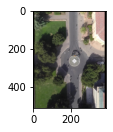

torch.Size([1, 7, 512, 384])
torch.Size([1, 5, 512, 384])
torch.Size([1, 5, 512, 384])


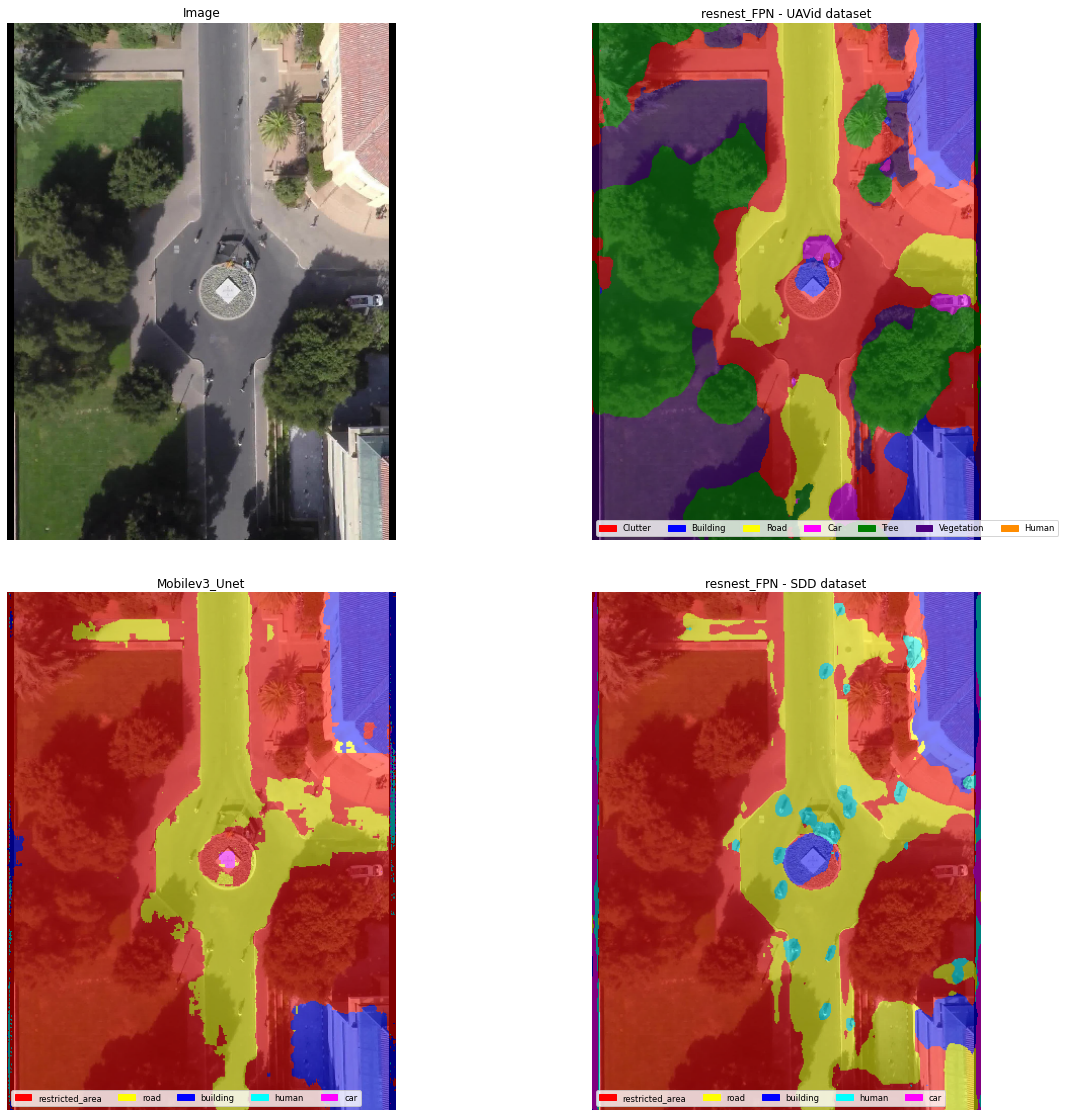

In [212]:
# Creating nice img
import matplotlib.gridspec as gridspec
img, labels = SDD_val[626]
plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

ax1 = plt.subplot(2,2,1)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.axis('off')
ax1.set_title('Image')
ax1.imshow(img)

################### UAVid
ax2 = plt.subplot(2,2,2)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.axis('off')
ax2.set_title('resnest_FPN - UAVid dataset')
tensor_img = preprocess_tr(image=img)['image'].unsqueeze(0)
preds = model_UAVid(tensor_img.cuda())
print(preds.shape)
pred_labels = torch.argmax(preds[0], dim=0).cpu().detach().numpy()
patches = []
COLORS = ('red', 'blue', 'yellow', 'magenta', 'green', 'indigo', 'darkorange', 'cyan', 'pink', 'yellowgreen')
CLASSES = ['Clutter', 'Building', 'Road', 'Car', 'Tree', 'Vegetation', 'Human']
for i, cls in enumerate(CLASSES):
    patches.append(mpatches.Patch(color=DEFAULT_COLORS[i], label=cls))
a = mask_to_overlay_image(img, pred_labels, colors=COLORS)
ax2.legend(handles=patches, ncol=7, bbox_to_anchor=(0, 0),
          loc='lower left', fontsize='small')
ax2.imshow(a)


###################
patches = []
COLORS = ('red', 'yellow', 'blue', 'cyan', 'magenta', 'indigo')
CLASSES = ['restricted_area', 'road', 'building', 'human', 'car']
for i, cls in enumerate(CLASSES):
    patches.append(mpatches.Patch(color=COLORS[i], label=cls))
################### ALL
ax3 = plt.subplot(2,2,3)
ax3.axis('off')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title('Mobilev3_Unet')
tensor_img = preprocess_tr(image=img)['image'].unsqueeze(0)
preds = model1(tensor_img.cuda())
print(preds.shape)
pred_labels = torch.argmax(preds[0], dim=0).cpu().detach().numpy()

a = mask_to_overlay_image(img, pred_labels, colors=COLORS)
ax3.legend(handles=patches, ncol=7, bbox_to_anchor=(0, 0),
          loc='lower left', fontsize='small')
ax3.imshow(a)

############ SDD
ax4 = plt.subplot(2,2,4)
ax4.axis('off')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_title('resnest_FPN - SDD dataset')
tensor_img = preprocess_tr(image=img)['image'].unsqueeze(0)
preds = model_SDD(tensor_img.cuda())
print(preds.shape)
pred_labels = torch.argmax(preds[0], dim=0).cpu().detach().numpy()

a = mask_to_overlay_image(img, pred_labels, colors=COLORS)
ax4.legend(handles=patches, ncol=7, bbox_to_anchor=(0, 0),
          loc='lower left', fontsize='small')
ax4.imshow(a)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig("overall.png", bbox_inches='tight')